In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from nltk.corpus import reuters
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from scipy import sparse
from tqdm import tqdm

In [ ]:
nltk.download('reuters')

[nltk_data] Downloading package reuters to /root/nltk_data...


True

In [ ]:
!unzip -q /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [ ]:
def get_corpus_text(categories):
    return [' '.join(reuters.words(file_id)) for file_id in reuters.fileids(categories=categories)]

In [ ]:
crude_dataset = get_corpus_text(categories=['crude'])
first_crude_text = crude_dataset[0]

print(f'Crude category includes {len(crude_dataset)} news.')
print('Crude category first news text is:')
print(first_crude_text)

Crude category includes 578 news.
Crude category first news text is:
JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWNWARDS The Ministry of International Trade and Industry ( MITI ) will revise its long - term energy supply / demand outlook by August to meet a forecast downtrend in Japanese energy demand , ministry officials said . MITI is expected to lower the projection for primary energy supplies in the year 2000 to 550 mln kilolitres ( kl ) from 600 mln , they said . The decision follows the emergence of structural changes in Japanese industry following the rise in the value of the yen and a decline in domestic electric power demand . MITI is planning to work out a revised energy supply / demand outlook through deliberations of committee meetings of the Agency of Natural Resources and Energy , the officials said . They said MITI will also review the breakdown of energy supply sources , including oil , nuclear , coal and natural gas . Nuclear energy provided the bulk of Japan ' s elect

In [ ]:
# Using only first 100 crude news
texts = crude_dataset[:100]

In [ ]:
def text_preprocessing(
        text: str,
        punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
        stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
) -> list:
    """
    A method to preprocess text
    """
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Dropping empty strings
    text = [x for x in text if x != '']

    # Dropping stop words
    text = [x for x in text if x not in stop_words]

    return text

In [ ]:
def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict

In [ ]:
# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

In [ ]:
def find_similar(word:str, embedding_dict:dict, top_n=10) -> list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]

In [ ]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list

# List of [Focus word, context word]
word_lists = []

# List of all news words
all_text = []

for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

In [ ]:
print('Some of Focus, Context pairs:')
print(word_lists[:5])
print(f'All news together includes {len(all_text)} words')

Some of Focus, Context pairs:
[['japan', 'to'], ['japan', 'revise'], ['to', 'revise'], ['to', 'japan'], ['to', 'long']]
All news together includes 14254 words


In [ ]:
# Create words dict
unique_word_dict = create_unique_word_dict(all_text)

In [ ]:
# Defining the number of features (unique words)
n_words = len(unique_word_dict)
# Getting all the unique words 
words = list(unique_word_dict.keys())

In [ ]:
print(f'There are {n_words} unique words.')

There are 2728 unique words.


In [ ]:
# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

56416it [00:04, 11853.21it/s]


In [ ]:
# Converting the matrices into tensors
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)

In [ ]:
print(f'X shape: {X.shape}')
print(f'Y shape: {Y.shape}')
print('X includes focus words')
print('Y includes context words')
print('So we have (x, y) == (focus, context) pairs')

X shape: (56416, 2728)
Y shape: (56416, 2728)
X includes focus words
Y includes context words
So we have (x, y) == (focus, context) pairs


In [ ]:
# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2728)]            0         
                                                                 
 dense (Dense)               (None, 2)                 5458      
                                                                 
 dense_1 (Dense)             (None, 2728)              8184      
                                                                 
Total params: 13,642
Trainable params: 13,642
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Optimizing the network weights
model.fit(
    x=X,
    y=Y,
    batch_size=256,
    epochs=1000,
)

Epoch 1/1000
221/221 [==============================] - 5s 18ms/step - loss: 7.7903
Epoch 2/1000
221/221 [==============================] - 4s 18ms/step - loss: 7.3412
Epoch 3/1000
221/221 [==============================] - 4s 18ms/step - loss: 6.8777
Epoch 4/1000
221/221 [==============================] - 4s 18ms/step - loss: 6.6751
Epoch 5/1000
221/221 [==============================] - 4s 18ms/step - loss: 6.6297
Epoch 6/1000
221/221 [==============================] - 4s 18ms/step - loss: 6.6157
Epoch 7/1000
221/221 [==============================] - 4s 18ms/step - loss: 6.6079
Epoch 8/1000
221/221 [==============================] - 4s 20ms/step - loss: 6.6026
Epoch 9/1000
221/221 [==============================] - 4s 18ms/step - loss: 6.5988
Epoch 10/1000
221/221 [==============================] - 4s 18ms/step - loss: 6.5958
Epoch 11/1000
221/221 [==============================] - 4s 18ms/step - loss: 6.5934
Epoch 12/1000
221/221 [==============================] - 7s 32ms/step - lo

In [ ]:
# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
    })    

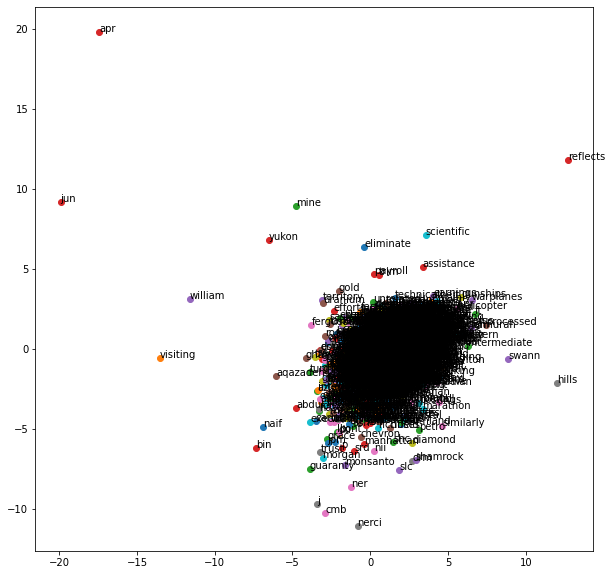

In [ ]:
# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1])) 

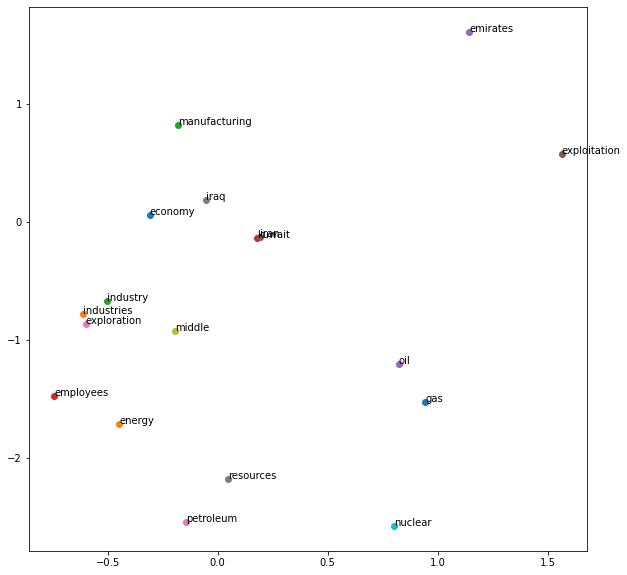

In [ ]:
new_words = [
    'gas', 'energy', 'industry', 'kuwait', 'oil', 'iran', 'petroleum', 'iraq',
    'middle', 'nuclear', 'economy', 'industries', 'manufacturing', 'employees',
    'emirates', 'exploitation', 'exploration', 'resources'
]

# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in new_words:
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1])) 

In [ ]:
my_words = [
    'iran', 'gas', 'oil', 'economic', 'industry',
    'manufacturing', 'energy', 'nuclear', 'emirates',
]

for word in my_words:
    similarity = find_similar(word, embedding_dict=embedding_dict, top_n=5)
    print(f'Similar words to {word}:')
    print(similarity)
    print()

Similar words to iran:
[('meetings', 0.01711179), ('kuwait', 0.017799867), ('communication', 0.027351283), ('inch', 0.028207982), ('panel', 0.045745846)]

Similar words to gas:
[('shares', 0.013574208), ('marketed', 0.19188003), ('obligations', 0.19762509), ('bombings', 0.19985059), ('own', 0.21956536)]

Similar words to oil:
[('eia', 0.0619546), ('remaining', 0.0642409), ('stake', 0.069517784), ('old', 0.07789461), ('everyone', 0.110637926)]

Similar words to economic:
[('believe', 0.02298409), ('that', 0.044410467), ('swedish', 0.04937736), ('they', 0.0564018), ('provisions', 0.06640995)]

Similar words to industry:
[('ec', 0.026133515), ('investigating', 0.041361853), ('latest', 0.055735853), ('agreeing', 0.07408273), ('sources', 0.078879856)]

Similar words to manufacturing:
[('lot', 0.028212644), ('aggressively', 0.051717106), ('building', 0.056598727), ('historic', 0.06897059), ('mergers', 0.07399485)]

Similar words to energy:
[('administration', 0.034194216), ('tracts', 0.04254